# LkHa 225S Fractional Fluxes


### Caltech Summer 2019

19 September 2020

### Imports 

In [1]:
import numpy as np
from scipy import optimize
from scipy import interpolate
from scipy import integrate
from scipy import signal
from astropy.convolution import convolve, convolve_fft
import matplotlib.pyplot as plt
from fu_ori_functions_oct11 import *
from fu_ori_classes_oct11 import *
import matplotlib.gridspec as gridspec
from PyAstronomy import pyasl
import spectres

### Constants (astronomy is in cgs, right?)

In [2]:
G = 6.67259e-8
SIG_SB = 5.67051e-5
M_SUN = 1.99e33
R_SUN = 6.96e10
L_SUN = 3.839e33
h_PLANCK = 6.6260755e-27
c_LIGHT = 2.99792458e10
k_BOLTZ = 1.380658e-16
sec_YEAR = 365*24*60*60

In [22]:
DIREC = '/Users/tonyrodriguez/Documents/Documents - Tony’s MacBook Pro/2019 Summer/Stellar Atmospheres/'

In [23]:
ATM_TABLE = dict()
ATMOS_FACTOR = 100

In [24]:
def direcToArray(directory):
    for temp in range(2000, 10000+ATMOS_FACTOR, ATMOS_FACTOR):
        for grav in [1.5, 4.0]:
            try:
                atmos_file = directory + 'pr.lte' + str(int(temp/ATMOS_FACTOR)) \
                        + '-' + str(grav) + '-0.0.spec'
                txt = open(atmos_file)
                fulltxt = txt.readlines()
                # Cleaning lines
                newtxt = []
                for i in range(len(fulltxt)):
                    line = fulltxt[i][:-1]
                    line = line.split()
                    newtxt.append(line)
        
                # Casting as floats
                newtxt = np.array(newtxt).astype(np.float64)
                
                # Choosing which model to use
                wav, lum = newtxt[:,0], newtxt[:,1]
                ATM_TABLE[(temp, grav)] = np.array([wav, lum])
            except:
                print('No atmosphere found for temp = ' + str(temp) + \
                      ' grav = ' + str(grav))

In [25]:
direcToArray(DIREC)

No atmosphere found for temp = 7100 grav = 1.5
No atmosphere found for temp = 7100 grav = 4.0
No atmosphere found for temp = 7300 grav = 1.5
No atmosphere found for temp = 7300 grav = 4.0
No atmosphere found for temp = 7500 grav = 1.5
No atmosphere found for temp = 7500 grav = 4.0
No atmosphere found for temp = 7700 grav = 1.5
No atmosphere found for temp = 7700 grav = 4.0
No atmosphere found for temp = 7900 grav = 1.5
No atmosphere found for temp = 7900 grav = 4.0
No atmosphere found for temp = 8100 grav = 1.5
No atmosphere found for temp = 8100 grav = 4.0
No atmosphere found for temp = 8300 grav = 1.5
No atmosphere found for temp = 8300 grav = 4.0
No atmosphere found for temp = 8500 grav = 1.5
No atmosphere found for temp = 8500 grav = 4.0
No atmosphere found for temp = 8700 grav = 1.5
No atmosphere found for temp = 8700 grav = 4.0
No atmosphere found for temp = 8900 grav = 1.5
No atmosphere found for temp = 8900 grav = 4.0
No atmosphere found for temp = 9100 grav = 1.5
No atmosphere

## Making an instance of the class FU Ori and testing

In [26]:
class FUOriEnvironment:
    
    # Initializer / Instance Attributes
    def __init__(self, wave_lower_spec, wave_upper_spec, wave_lower_SED, wave_upper_SED):
        
        self.wave_lower_spec = wave_lower_spec
        self.wave_upper_spec = wave_upper_spec
        self.wave_lower_SED = wave_lower_SED
        self.wave_upper_SED = wave_upper_SED
        
        # Storing classes
        self.fuori = []
        self.rot_star = 0
        self.disk_atm = []
        
        print('Created environment.')
        
    # instance methods
    
    # Creating FU Ori object as accretion disk
    def createFUOri(self, r_star, r_outer, m_star, m_dot, inc, a_v, dist, grav, direc,atm_table):
        print('Creating FU Ori object...')
        fuori = FUOri(r_star, r_star, r_outer, m_star, m_dot, np.radians(inc), a_v,  atm_table)
        print('Creating disk annuli...')
        fuori.setAnnuliValues(10000, 2000, 200, 1*r_star)
#         fuori.r_a, fuori.r_b, fuori.temps = makeMod(fuori.r_a, fuori.r_b, fuori.temps, bins=20)
        print('Reading stellar atmosphere directory...')
        fuori.createAnnuliFromDirec(grav, direc, model='stellar atmospheres')
        print('Preparing annuli for broadening and summing...')
        fuori.prepareAnnuli(self.wave_lower_spec,self.wave_upper_spec, \
                            binning=1, broaden=True, interp_type='linear')
        print('Creating model spectrum...')
        fuori.createModelSpectrum('stellar atmospheres', broaden=True)
        print('FU Ori object created.')
        self.fuori.append(fuori)
    
    # Creating rotating star
    def createRotStar(self, temp, r_star, m_star, inc, a_v, dist, grav, direc, atm_table):
        self.rot_star = Star(temp, grav, m_star, r_star, direc, np.radians(inc), a_v, atm_table) 
        self.rot_star.setSpectrumFromDirec('stellar atmospheres', temp, grav)
        self.rot_star.prepareSpectrum(self.wave_lower_spec, self.wave_upper_spec, 1, 'linear')
        self.rot_star.broadenStellarSpectrum()
        
    def createDiskAtm(self, temp, grav, vsini, direc, atm_table):
        disk_atm = DiskAtmosphere(temp, grav, vsini, direc, atm_table) 
        disk_atm.setSpectrumFromDirec('stellar atmospheres', temp, grav)
        disk_atm.prepareSpectrum(self.wave_lower_spec, self.wave_upper_spec, 1, 'linear')
        disk_atm.broadenDiskAtmSpectrum()
        self.disk_atm.append(disk_atm)
    
    # For viewing model spectrum
    def viewModelSpectrum(self, wave_lower, wave_upper, obj_type, obj_num, broaden, redden):
        if obj_type == 'fu ori':
            return self.fuori[obj_num].viewModelSpectrum(wave_lower, wave_upper, broaden, redden)
        elif obj_type == 'rotating star':
            return self.rot_star.getLuminosity(wave_lower, wave_upper, broaden, redden)
        elif obj_type == 'disk atmosphere':
            return self.disk_atm[obj_num].getLuminosity(wave_lower, wave_upper, 'broadened')
    
    # For viewing model SED
    def viewModelSED(self, wave_lower, wave_upper, broaden):
        waves, lums = self.fuori.viewModelSpectrum(wave_lower, wave_upper, broaden, redden)
        return np.log10(waves*1e-4), np.log10(np.cos(np.radians(self.inc))*waves*1e-8*lums/(2*np.pi*(self.dist**2)))

    # Useful modules
    def viewFracLums(self, wave_lower, wave_upper, obj_num, data_type, x_axis_type):
        return self.fuori[obj_num].calculateFracLums(wave_lower, wave_upper, data_type, x_axis_type)
    
    def viewGravComparison(self, obj_nums, wave_lower, wave_upper, broaden, redden):
        obj_n1, obj_n2 = obj_nums
        wav, lum1 = self.viewModelSpectrum(wave_lower, wave_upper, 'fu ori', obj_n1, broaden, redden)
        wav, lum2 = self.viewModelSpectrum(wave_lower, wave_upper, 'fu ori', obj_n2, broaden, redden)
        lum_diff = np.abs(lum2 - lum1)
        return wav, lum_diff    

In [27]:
PARAMS = [8.41, 4.75, -4.48, 7.78, 45, 0]

In [28]:
gaia17bpi_env = FUOriEnvironment(3.95e3, 4.55e3, 0, 0)
gaia17bpi_env2 = FUOriEnvironment(7.95e3, 8.55e3, 0, 0)
gaia17bpi_env3 = FUOriEnvironment(22.95e3, 23.55e3, 0, 0)
gaia17bpi_envNEW = FUOriEnvironment(3.95e3, 23.55e3, 0, 0)

R_OUTER = 200*R_SUN
DIST = 920*3.08567758128e18
# Spectrum fit
%time gaia17bpi_env.createFUOri(r_star = PARAMS[1]*R_SUN, r_outer = R_OUTER, m_star = PARAMS[0]*M_SUN,\
                          m_dot = (10**PARAMS[2]) * M_SUN / 3.154e7, inc = PARAMS[4],\
                                a_v = PARAMS[3],dist = DIST, grav = 1.5, \
                                direc = DIREC, atm_table=ATM_TABLE)

%time gaia17bpi_envNEW.createFUOri(r_star = PARAMS[1]*R_SUN, r_outer = R_OUTER, m_star = PARAMS[0]*M_SUN,\
                          m_dot = (10**PARAMS[2]) * M_SUN / 3.154e7, inc = PARAMS[4],\
                                a_v = PARAMS[3],dist = DIST, grav = 1.5, \
                                direc = DIREC, atm_table=ATM_TABLE)


Created environment.
Created environment.
Created environment.
Created environment.
Creating FU Ori object...
Creating disk annuli...
Reading stellar atmosphere directory...
Used stellar atmosphere at T = 9400.
Used stellar atmosphere at T = 9200.
Used stellar atmosphere at T = 9000.
Used stellar atmosphere at T = 8800.
Used stellar atmosphere at T = 8600.
Used stellar atmosphere at T = 8400.
Used stellar atmosphere at T = 8200.
Used stellar atmosphere at T = 8000.
Used stellar atmosphere at T = 7800.
Used stellar atmosphere at T = 7600.
Used stellar atmosphere at T = 7400.
Used stellar atmosphere at T = 7200.
Used stellar atmosphere at T = 7000.
Used stellar atmosphere at T = 6800.
Used stellar atmosphere at T = 6600.
Used stellar atmosphere at T = 6400.
Used stellar atmosphere at T = 6200.
Used stellar atmosphere at T = 6000.
Used stellar atmosphere at T = 5800.
Used stellar atmosphere at T = 5600.
Used stellar atmosphere at T = 5400.
Used stellar atmosphere at T = 5200.
Used stellar

/Users/tonyrodriguez/Documents/Documents - Tony’s MacBook Pro/2019 Summer/Jupyter Notebooks/fu_ori_functions_oct11.py:134: RuntimeWarning: overflow encountered in exp
  term2 = (np.exp(h_PLANCK*c_LIGHT/(wavelength*k_BOLTZ*temp))-1)**(-1)


No stellar atmosphere for annulus of T = 1438. Used blackbody.
No stellar atmosphere for annulus of T = 1404. Used blackbody.
No stellar atmosphere for annulus of T = 1372. Used blackbody.
No stellar atmosphere for annulus of T = 1341. Used blackbody.
No stellar atmosphere for annulus of T = 1312. Used blackbody.
No stellar atmosphere for annulus of T = 1285. Used blackbody.
No stellar atmosphere for annulus of T = 1258. Used blackbody.
No stellar atmosphere for annulus of T = 1233. Used blackbody.
No stellar atmosphere for annulus of T = 1209. Used blackbody.
No stellar atmosphere for annulus of T = 1186. Used blackbody.
No stellar atmosphere for annulus of T = 1165. Used blackbody.
No stellar atmosphere for annulus of T = 1144. Used blackbody.
No stellar atmosphere for annulus of T = 1124. Used blackbody.
No stellar atmosphere for annulus of T = 1104. Used blackbody.
Preparing annuli for broadening and summing...
Annuli prepared from 3950-23550 Angstrom with binning of 1 Angstrom. Br

## Fractional Fluxes

In [29]:
temp, frac_lums = gaia17bpi_envNEW.viewFracLums(4.0e3, 4.1e3, 0, 'broadened', 'temperature')
temp2, frac_lums2 = gaia17bpi_envNEW.viewFracLums(4.4e3, 4.5e3, 0, 'broadened', 'temperature')
temp3, frac_lums3 = gaia17bpi_envNEW.viewFracLums(8.0e3, 8.1e3, 0, 'broadened', 'temperature')
temp4, frac_lums4 = gaia17bpi_envNEW.viewFracLums(8.4e3, 8.5e3, 0, 'broadened', 'temperature')
temp5, frac_lums5 = gaia17bpi_envNEW.viewFracLums(23.0e3, 23.1e3, 0, 'broadened', 'temperature')
temp6, frac_lums6 = gaia17bpi_envNEW.viewFracLums(23.4e3, 23.5e3, 0, 'broadened', 'temperature')

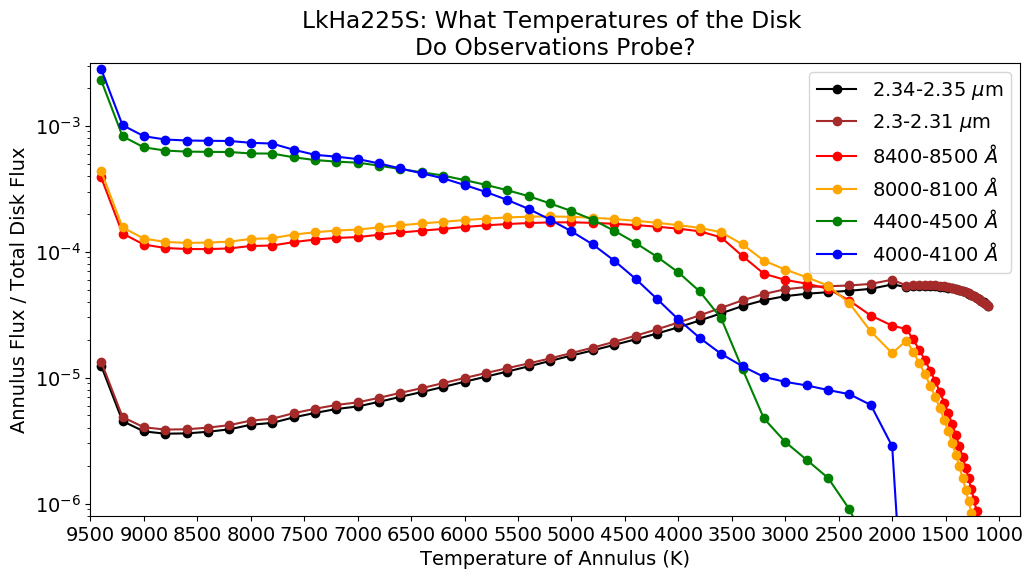

In [30]:
fig=plt.figure(figsize=(12, 6), dpi= 100)
plt.rcParams.update({'font.size': 14})
plt.title('LkHa225S: What Temperatures of the Disk \nDo Observations Probe?')
plt.ylabel('Annulus Flux / Total Disk Flux')
plt.xlabel('Temperature of Annulus (K)')
plt.semilogy(temp6, frac_lums6, 'ko-', label=r'2.34-2.35 $\mu$m')
plt.semilogy(temp5, frac_lums5, 'o-', color = 'brown', label=r'2.3-2.31 $\mu$m')
plt.semilogy(temp4, frac_lums4, 'o-',color='red', label=r'8400-8500 $\AA$')
plt.semilogy(temp3, frac_lums3, 'o-',color='orange', label=r'8000-8100 $\AA$')
plt.semilogy(temp2, frac_lums2, 'go-', label=r'4400-4500 $\AA$')
plt.semilogy(temp, frac_lums, 'bo-', label=r'4000-4100 $\AA$')


plt.xlim(gaia17bpi_env.fuori[0].annuli[0].temp+100, 800)
plt.xticks(np.arange(1000, gaia17bpi_env.fuori[0].annuli[0].temp + 500, 500))
plt.ylim(0.8e-6, 10**(-2.5))
plt.legend()
# plt.savefig('hbc722_fracflux_temp.png', dpi=200, bbox_inches='tight')
plt.show()

In [31]:
rad, frac_lums = gaia17bpi_envNEW.viewFracLums(4.0e3, 4.1e3, 0, 'broadened', 'distance')
rad2, frac_lums2 = gaia17bpi_envNEW.viewFracLums(4.4e3, 4.5e3, 0, 'broadened', 'distance')
rad3, frac_lums3 = gaia17bpi_envNEW.viewFracLums(8.0e3, 8.1e3, 0, 'broadened', 'distance')
rad4, frac_lums4 = gaia17bpi_envNEW.viewFracLums(8.4e3, 8.5e3, 0, 'broadened', 'distance')
rad5, frac_lums5 = gaia17bpi_envNEW.viewFracLums(23.0e3, 23.1e3, 0, 'broadened', 'distance')
rad6, frac_lums6 = gaia17bpi_envNEW.viewFracLums(23.4e3, 23.5e3, 0, 'broadened', 'distance')

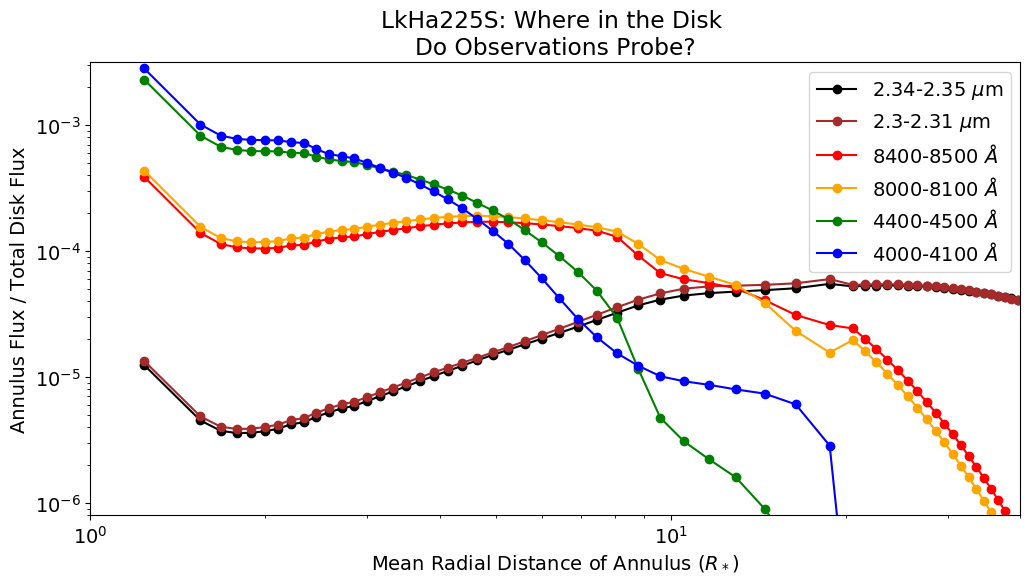

In [32]:
fig=plt.figure(figsize=(12, 6), dpi= 100)
plt.rcParams.update({'font.size': 14})
plt.title('LkHa225S: Where in the Disk \nDo Observations Probe?')

plt.loglog(rad6, frac_lums6, 'ko-', label=r'2.34-2.35 $\mu$m')
plt.loglog(rad5, frac_lums5,  'o-', color = 'brown', label=r'2.3-2.31 $\mu$m')
plt.loglog(rad4, frac_lums4,  'o-',color='red', label=r'8400-8500 $\AA$')
plt.loglog(rad3, frac_lums3, 'o-',color='orange', label=r'8000-8100 $\AA$')
plt.loglog(rad2, frac_lums2, 'go-', label=r'4400-4500 $\AA$')
plt.loglog(rad, frac_lums,  'bo-', label=r'4000-4100 $\AA$')

plt.ylabel('Annulus Flux / Total Disk Flux')
plt.xlabel(r'Mean Radial Distance of Annulus ($R_*$)')

plt.xlim(1, 40)
plt.ylim(0.8e-6, 10**(-2.5))
plt.legend()

# plt.savefig('hbc722_fracflux_rad.png', dpi=200, bbox_inches='tight')

plt.show()

## New plots

In [33]:
def waveSpeedPlot(wave_start, wave_stop, wave_step):
    rads, fracs = [], []
    wave_list = np.arange(wave_start, wave_stop, wave_step)
    for i in range(len(wave_list)-1):
        rads.append(gaia17bpi_envNEW.viewFracLums(wave_list[i], wave_list[i+1], 0, 'interpolated', 'distance')[0])
        fracs.append(gaia17bpi_envNEW.viewFracLums(wave_list[i], wave_list[i+1], 0, 'interpolated', 'distance')[1])
    return rads, fracs
    

In [34]:
def waveSpeedPlotTemp(wave_start, wave_stop, wave_step):
    temps, fracs = [], []
    wave_list = np.arange(wave_start, wave_stop, wave_step)
    for i in range(len(wave_list)-1):
        temps.append(gaia17bpi_envNEW.viewFracLums(wave_list[i], wave_list[i+1], 0, 'interpolated', 'temperature')[0])
        fracs.append(gaia17bpi_envNEW.viewFracLums(wave_list[i], wave_list[i+1], 0, 'interpolated', 'temperature')[1])
    return temps, fracs
    

In [35]:
rads, fracs = waveSpeedPlot(4e3, 23e3, 200)
temps, fracsTemp = waveSpeedPlotTemp(4e3, 23e3, 200)
actual_mass = gaia17bpi_envNEW.fuori[0].m_star
actual_rad = gaia17bpi_envNEW.fuori[0].r_star
vels = np.sqrt(G*actual_mass/(actual_rad*np.array(rads)))

In [36]:
avg_speeds = []
for i in range(len(rads)):
    avg_speeds.append(np.average(vels[i]*1e-5, weights=fracs[i]))

In [37]:
avg_temps = []
for i in range(len(temps)):
    avg_temps.append(np.average(temps[i], weights=fracsTemp[i]))

In [38]:
temps_plot = gaia17bpi_env.fuori[0].temps

In [39]:
radii_plot = gaia17bpi_env.fuori[0].r_a/gaia17bpi_env.fuori[0].r_star

### Plots for publication

In [40]:
gaia17bpi_envNEW.fuori[0].getTotalLum()/L_SUN

879.8594787023785

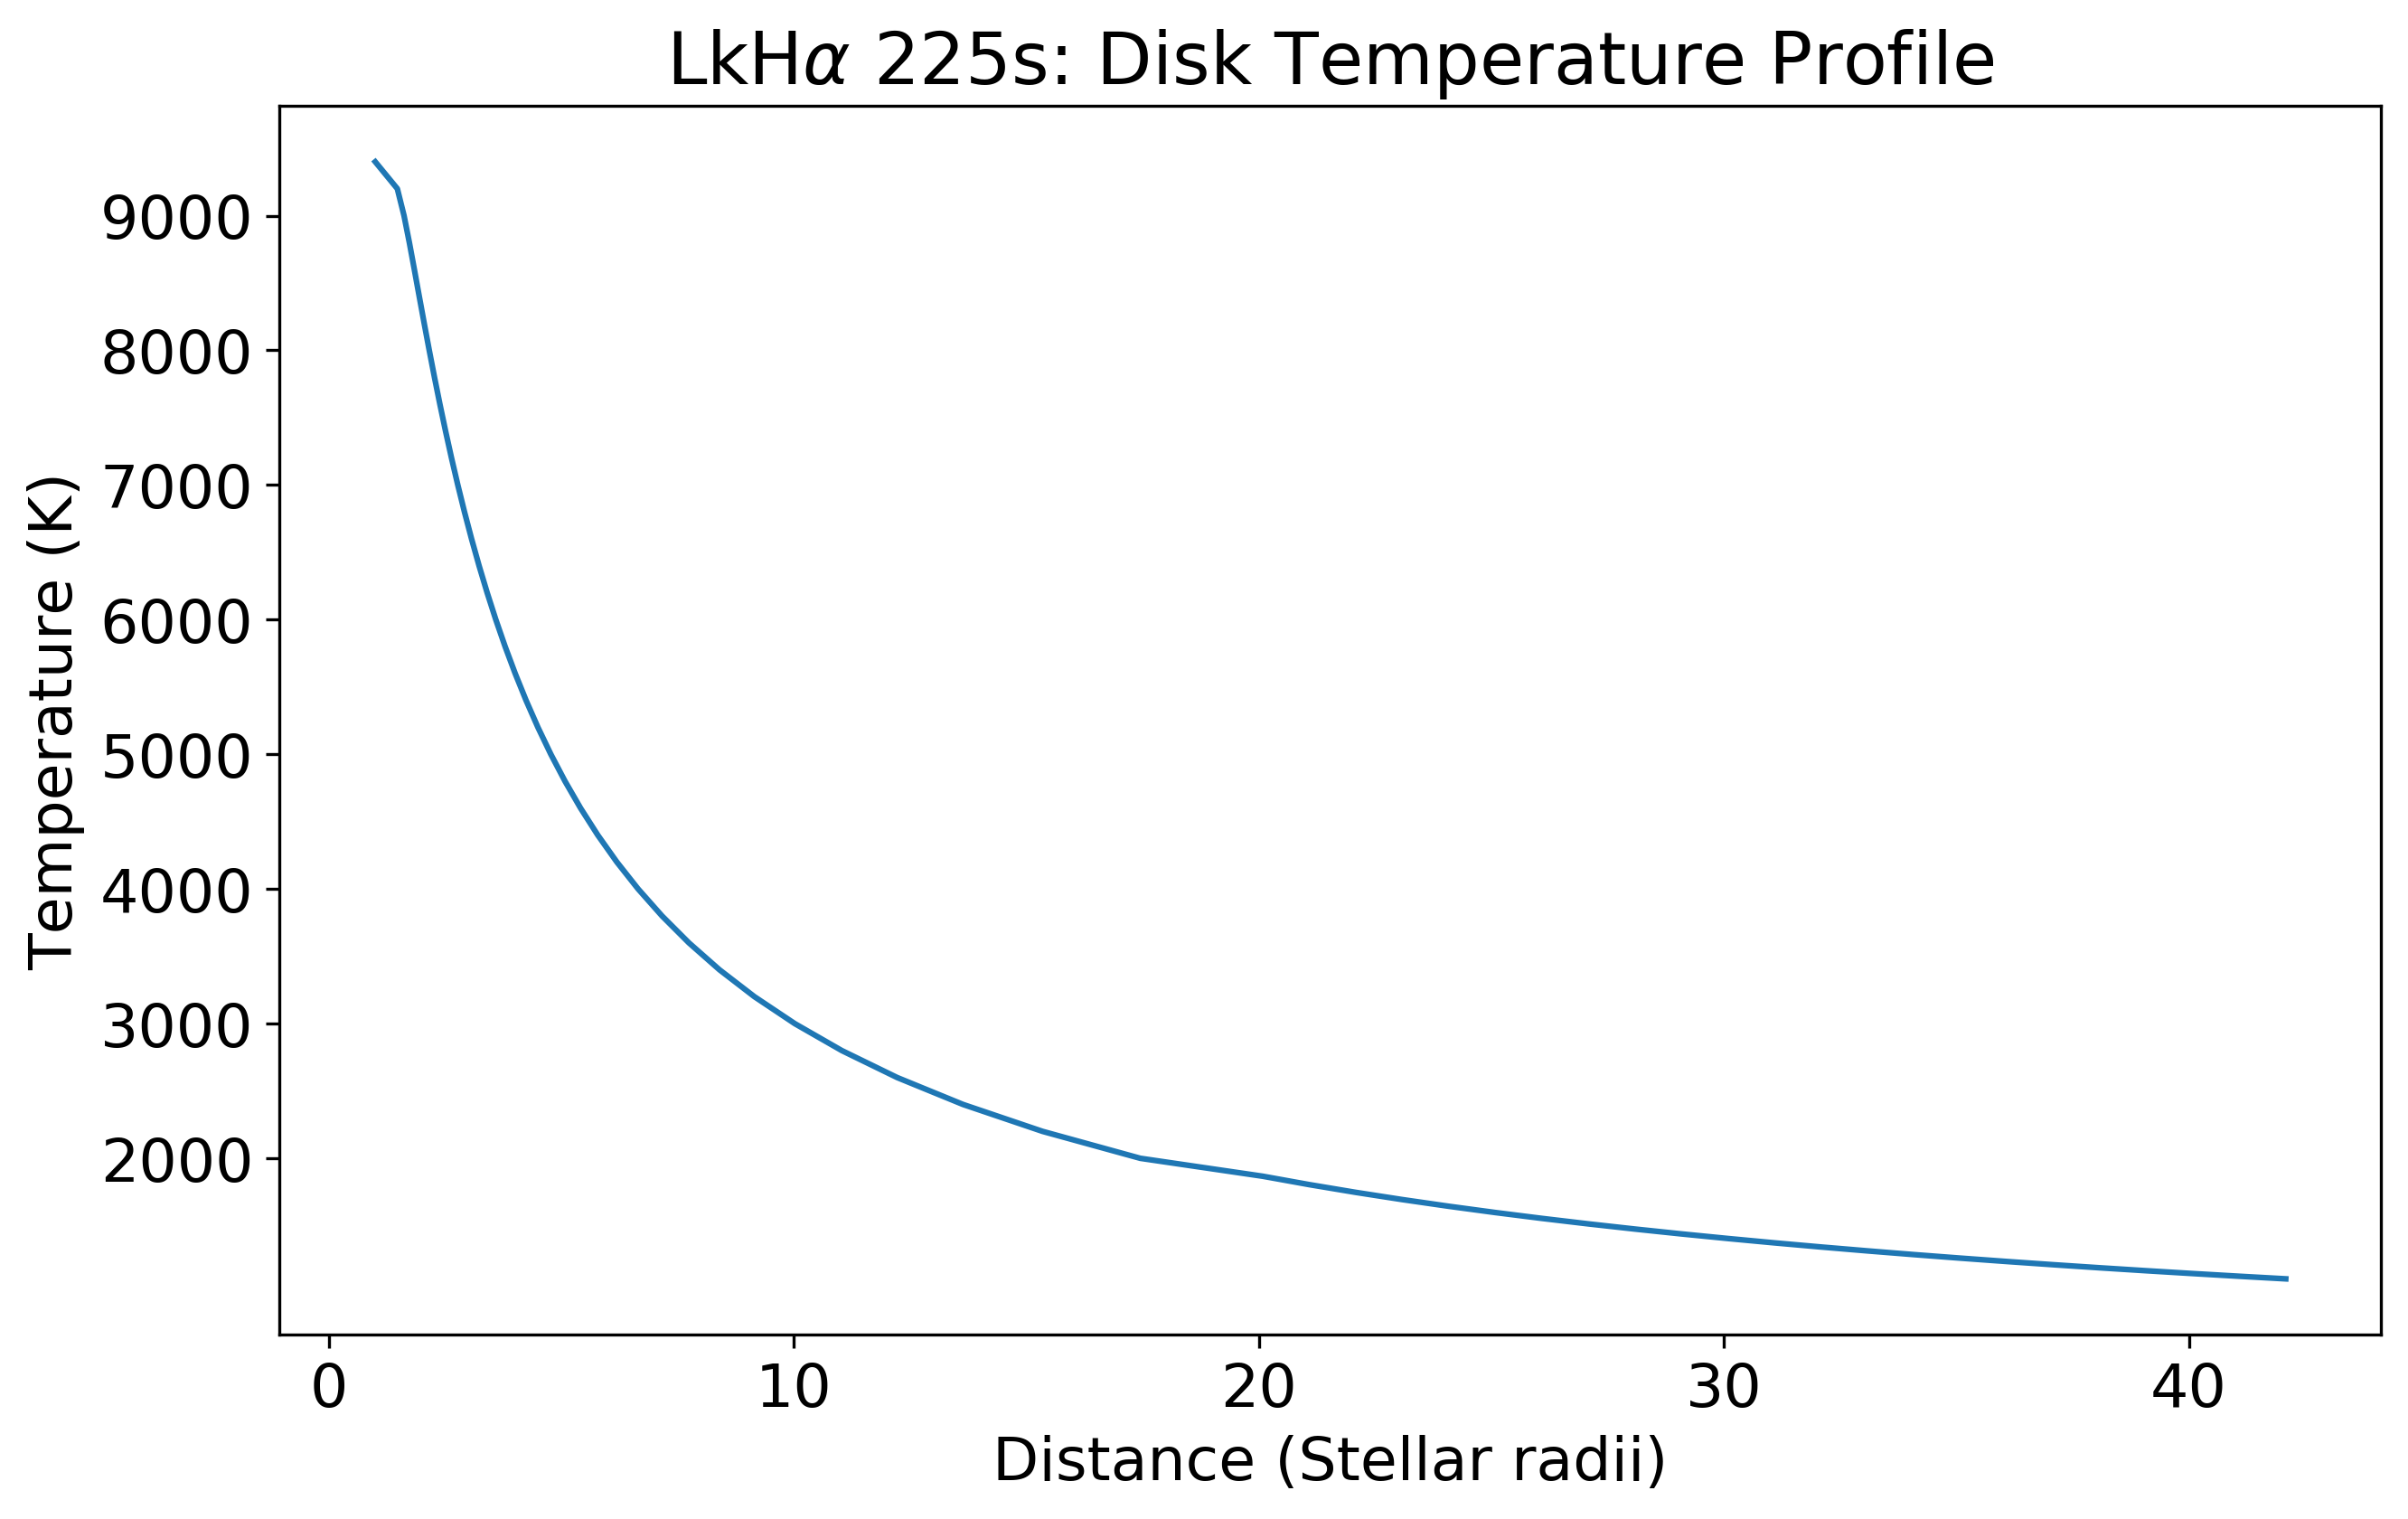

In [43]:
fig=plt.figure(figsize=(10, 6), dpi= 300)
plt.rcParams.update({'font.size': 16})
plt.title(r'LkH$\alpha$ 225s: Disk Temperature Profile')

plt.plot(radii_plot, temps_plot)
plt.ylabel('Temperature (K)')
plt.xlabel('Distance (Stellar radii)')
plt.yticks(np.arange(2000,10000, 1000))
plt.show()

In [45]:
import csv
with open('lkha225s_temp_radius.csv', 'w') as f:
    writer = csv.writer(f, delimiter=' ')
    writer.writerows((radii_plot, temps_plot))

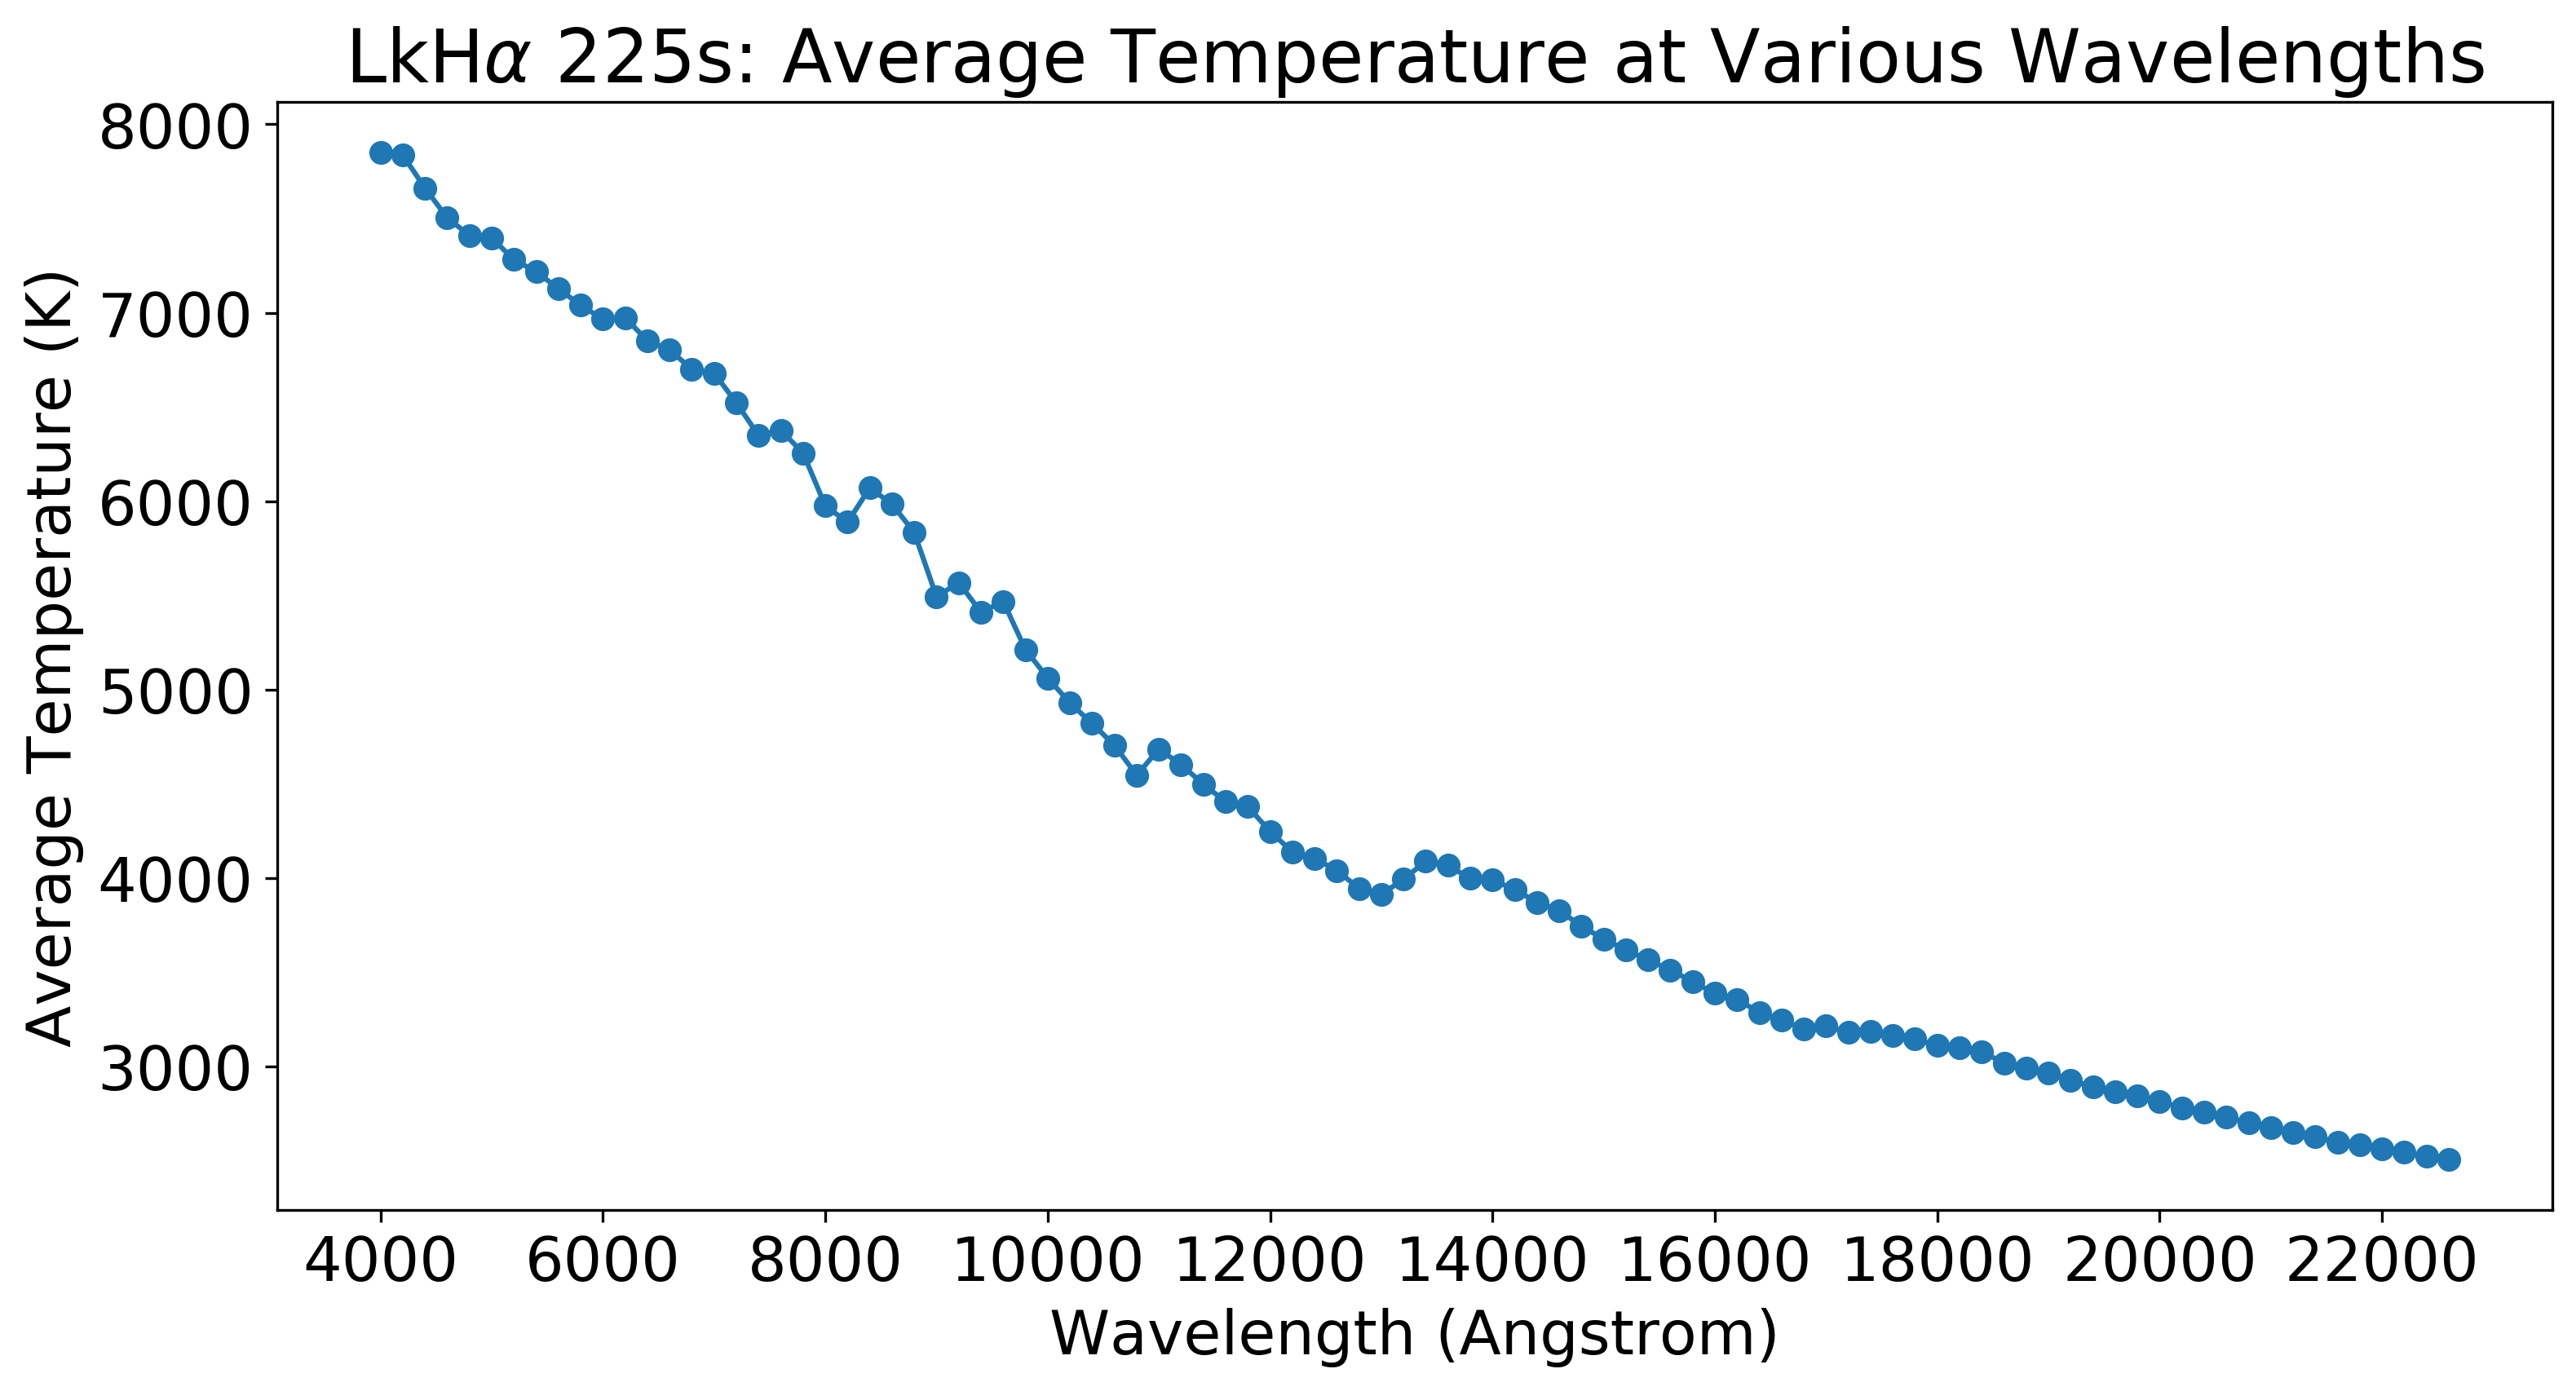

In [46]:
fig=plt.figure(figsize=(12, 6), dpi= 300)
plt.rcParams.update({'font.size': 18})
plt.title(r'LkH$\alpha$ 225s: Average Temperature at Various Wavelengths')

plt.plot(np.arange(4e3, 23e3-200, 200), avg_temps, 'o-')
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Average Temperature (K)')
plt.xticks(np.arange(4e3, 23e3, 2000))

plt.show()

In [47]:
import csv
with open('lkha225s_temp_wavelength.csv', 'w') as f:
    writer = csv.writer(f, delimiter=' ')
    writer.writerows((np.arange(4e3, 23e3-200, 200), avg_temps))

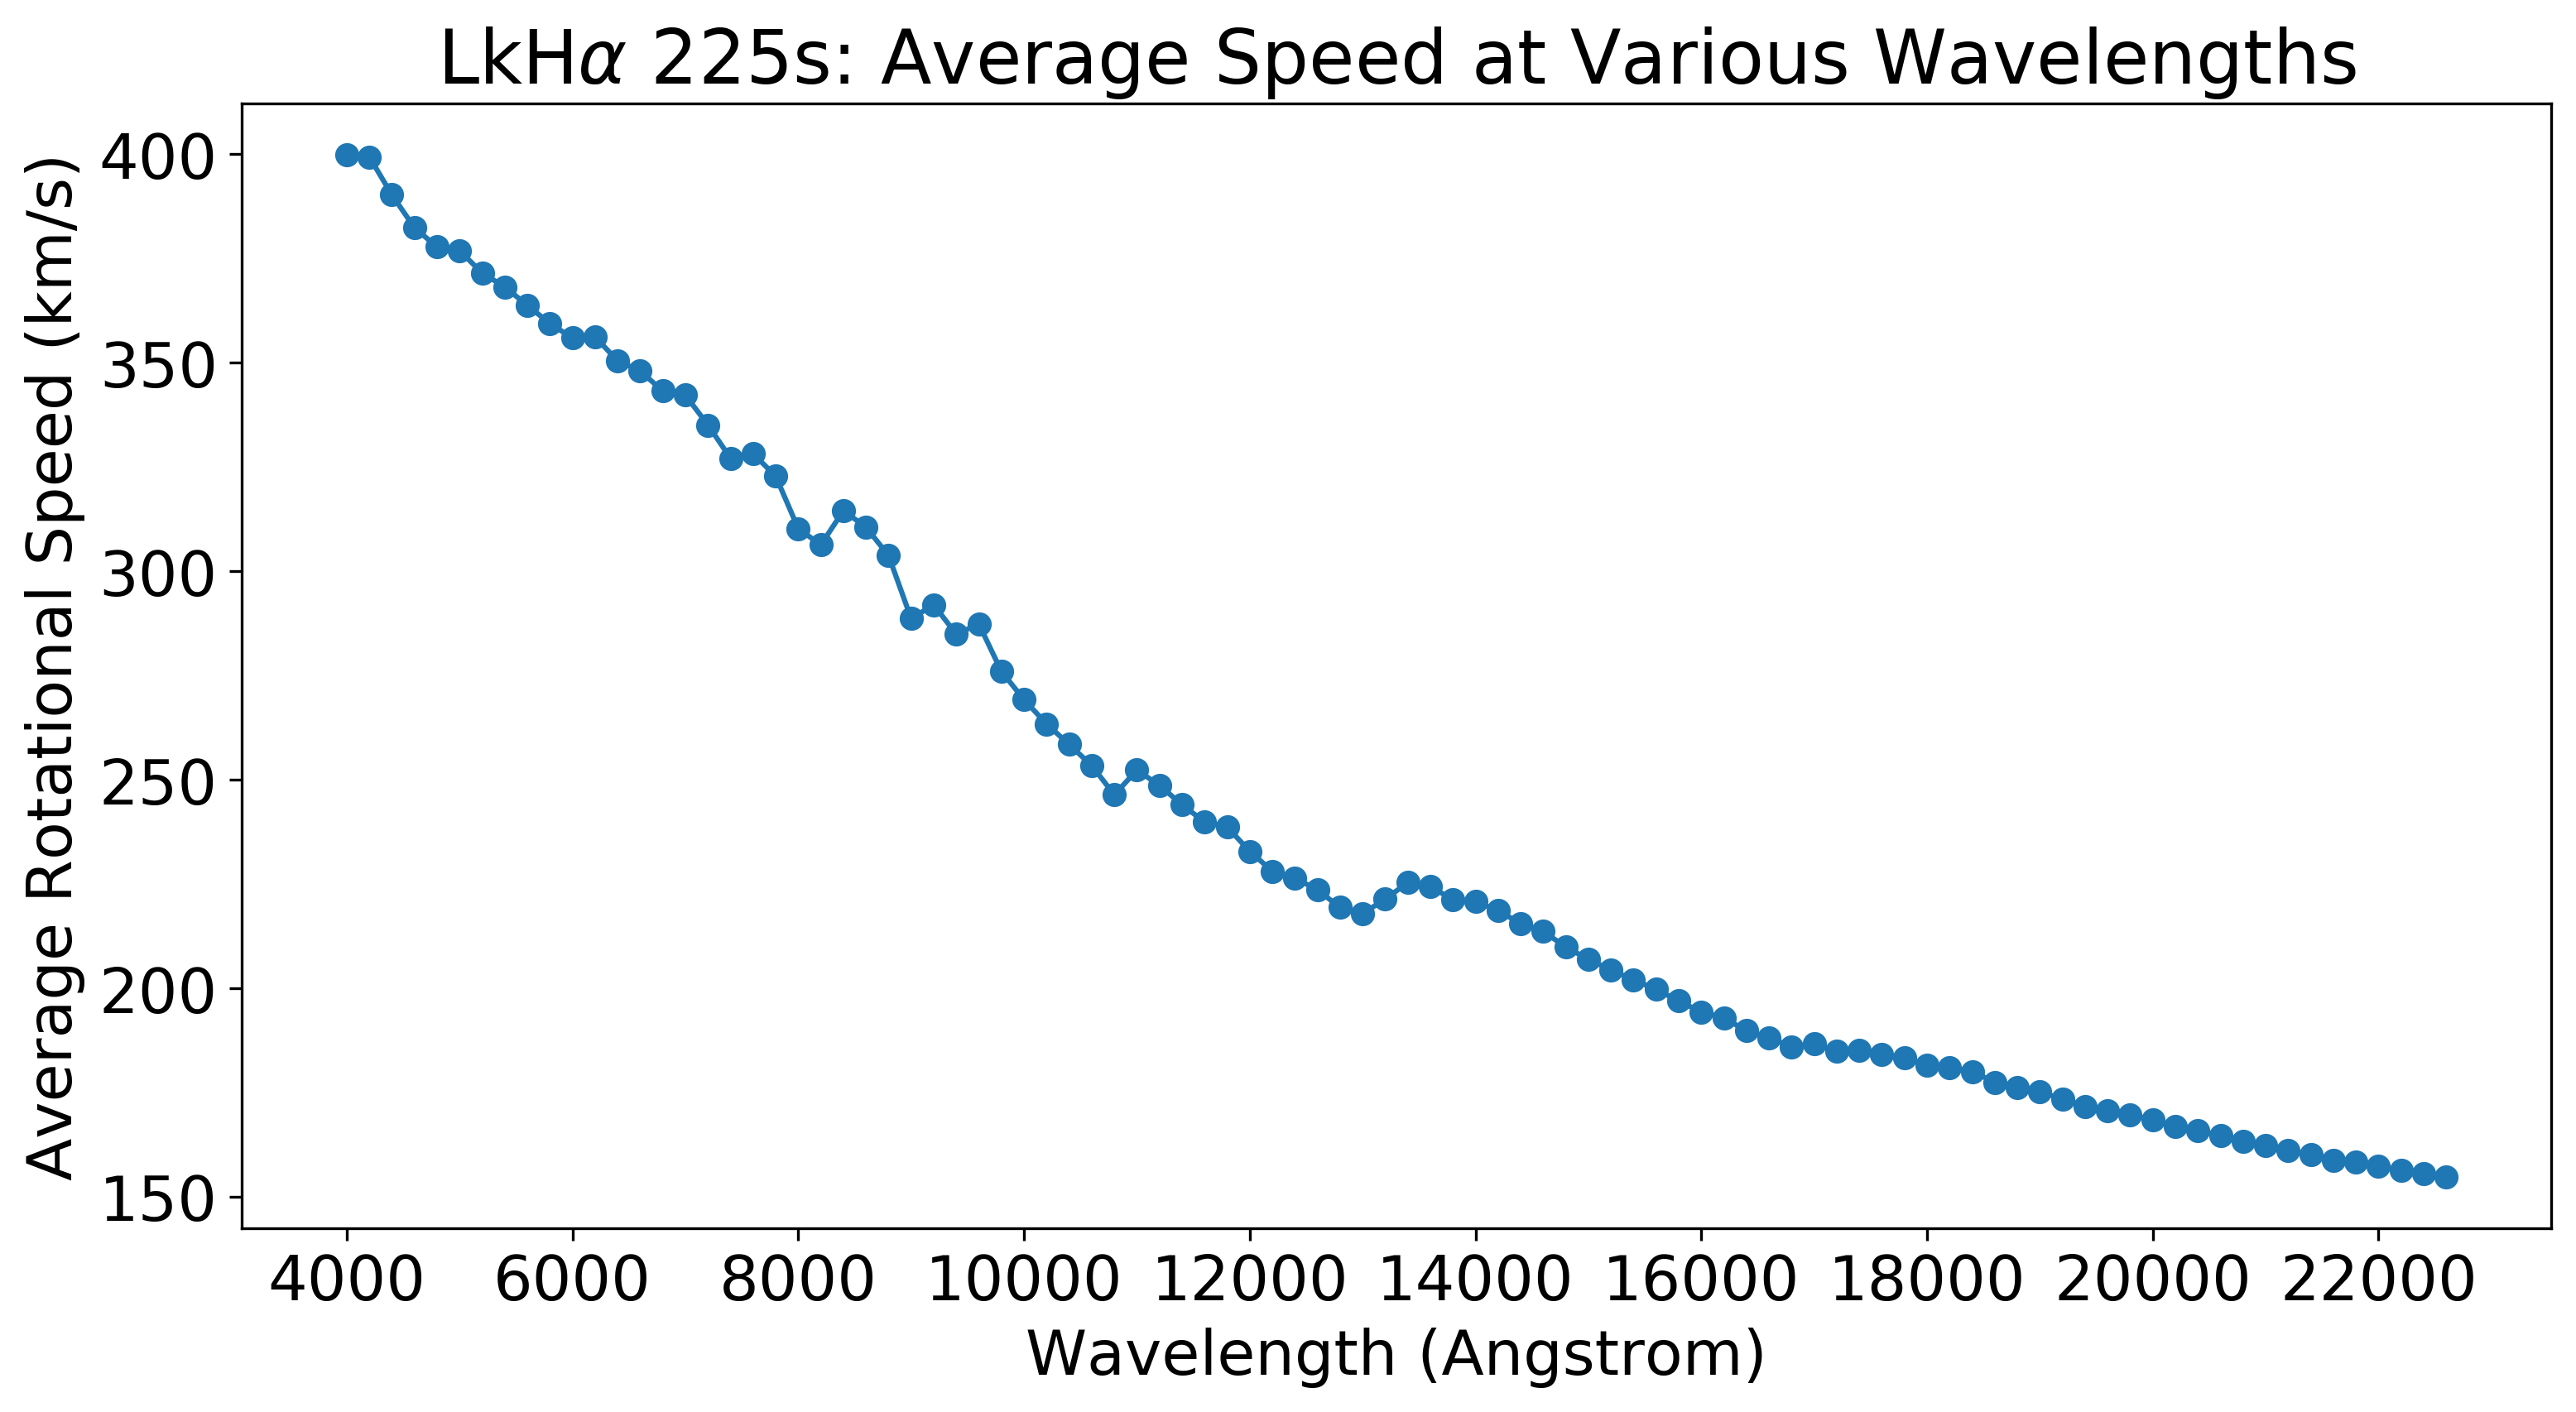

In [78]:
fig=plt.figure(figsize=(12, 6), dpi= 300)
plt.rcParams.update({'font.size': 18})
plt.title(r'LkH$\alpha$ 225s: Average Speed at Various Wavelengths')

plt.plot(np.arange(4e3, 23e3-200, 200), avg_speeds, 'o-')
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Average Rotational Speed (km/s)')
plt.xticks(np.arange(4e3, 23e3, 2000))

plt.show()

In [20]:
import csv
with open('lkha225s_wavelength_speed.csv', 'w') as f:
    writer = csv.writer(f, delimiter=' ')
    writer.writerows(zip(np.arange(4e3, 23e3-200, 200), avg_speeds))